# [Plant Seedlings Classification](https://www.kaggle.com/competitions/plant-seedlings-classification/code)


In [89]:
from copy import deepcopy
from datetime import datetime
from os import cpu_count, listdir, path
from pathlib import Path
from random import choice, seed
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Global Variables


In [76]:
# Metal Performance Shaders (MPS) - Apple Metal GPU acceleration
def get_mps_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        x = torch.ones(1, device=device)
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        x = torch.ones(1, device=device)
    else:
        device = None
    return device


DEVICE = get_mps_device()

DATA_ROOT = Path("./data")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"

RANDOM_SEED = 42
BATCH_SIZE = 32

print(f"Torch version: {torch.__version__}")
print(f"CPU cores: {cpu_count()}")

print(f"DEVICE: {DEVICE}")
print(f"DATA_ROOT: {DATA_ROOT}")
print("Random seed:", RANDOM_SEED)
print("Batch size:", BATCH_SIZE)

Torch version: 2.5.1
DEVICE: mps
DATA_ROOT: data
Random seed: 42
Batch size: 32


## Reproducibility


In [77]:
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Loading


In [78]:
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]
transform_resize = (224, 224)

transform = transforms.Compose(
    [
        transforms.Resize(transform_resize),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=transform_mean, std=transform_std),
    ]
)

dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

len_dataset = len(dataset)
print(f"Dataset length: {len_dataset}")
print(f"Dataset classes ({len(dataset.classes)}): {dataset.classes}")

Dataset length: 4750
Dataset classes (12): ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Class Distribution


In [79]:
label_counts = {}
for label in listdir(TRAIN_DIR):
    label_path = path.join(TRAIN_DIR, label)

    if path.isdir(label_path):
        num_files = len(
            [f for f in listdir(label_path) if path.isfile(path.join(label_path, f))]
        )
        label_counts[label] = num_files

fig = (
    px.bar(
        x=list(label_counts.keys()),
        y=list(label_counts.values()),
        title="Class distribution",
    )
    .update_xaxes(title="Class", categoryorder="total descending")
    .update_yaxes(title="Count")
)
fig.show()

##


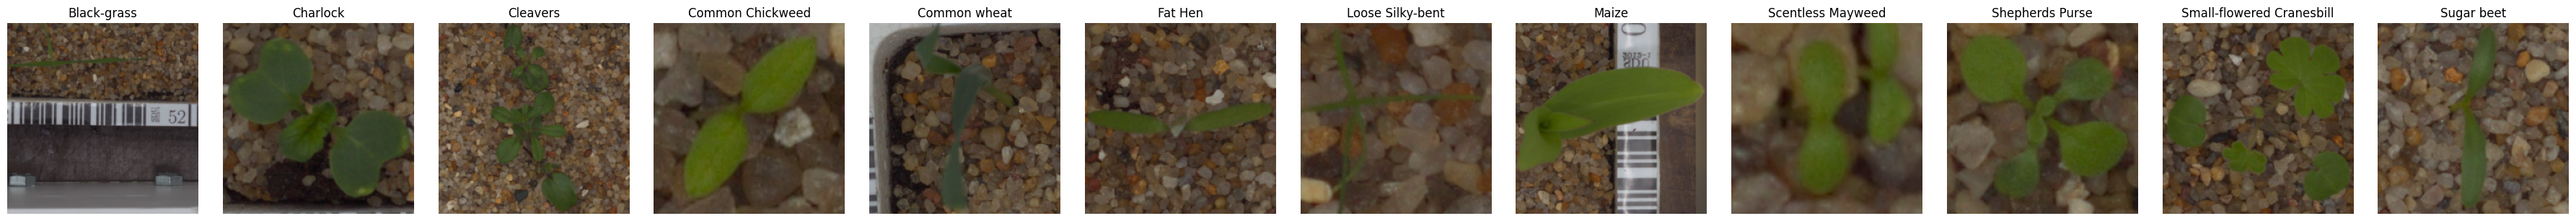

In [80]:
num_classes = len(dataset.classes)
class_to_indices: Dict[int, List[int]] = {}
for i, (_, label) in enumerate(dataset.samples):
    if label not in class_to_indices:
        class_to_indices[label] = []
    class_to_indices[label].append(i)

fig: Figure
axs: List[Axes]
fig, axs = plt.subplots(1, num_classes, figsize=(3 * num_classes, 3))

for class_idx, ax in zip(range(num_classes), axs):
    sample_idx = choice(class_to_indices[class_idx])

    img_tensor: Tensor
    lbl: int
    img_tensor, lbl = dataset[sample_idx]

    img_unnormalized: torch.Tensor = img_tensor * torch.tensor(transform_std).view(
        3, 1, 1
    ) + torch.tensor(transform_mean).view(3, 1, 1)

    # Convert from CxHxW to HxWxC
    img_np = img_unnormalized.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(dataset.classes[class_idx])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Splitting Data


In [81]:
len_vald = int(0.2 * len_dataset)
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [len_dataset - len_vald, len_vald]
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

Train dataset length: 3800
Validation dataset length: 950


## Model


In [82]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(
    in_features=model.fc.in_features, out_features=len(dataset.classes)
)
model = model.to(DEVICE)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
LR = 0.001
PATIENCE = 3
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

best_model_wts = deepcopy(model.state_dict())
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    running_train_loss = 0.0

    # Training
    for images, labels in train_loader:
        images: Tensor
        labels: Tensor
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss: Tensor = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%"
    )

    # Early stopping check
    if avg_val_loss < best_val_loss:
        print("Validation loss improved, saving model checkpoint...")
        best_val_loss = avg_val_loss
        best_model_wts = deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(
            f"No improvement in validation loss. Early stopping counter: {early_stop_counter}/{PATIENCE}"
        )
    if early_stop_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)
torch.save(model, DATA_ROOT / "model.pth")
print("Training complete. Best model saved and loaded.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [01:39<14:52, 99.13s/it]

Train Loss: 0.7707 | Val Loss: 1.2378 | Val Accuracy: 63.89%
Validation loss improved, saving model checkpoint...
Epoch 2/10


 20%|██        | 2/10 [03:18<13:13, 99.22s/it]

Train Loss: 0.4588 | Val Loss: 0.4841 | Val Accuracy: 82.84%
Validation loss improved, saving model checkpoint...
Epoch 3/10


 30%|███       | 3/10 [04:58<11:38, 99.83s/it]

Train Loss: 0.3130 | Val Loss: 0.5282 | Val Accuracy: 81.37%
No improvement in validation loss. Early stopping counter: 1/3
Epoch 4/10


 40%|████      | 4/10 [06:40<10:03, 100.56s/it]

Train Loss: 0.2843 | Val Loss: 0.4333 | Val Accuracy: 84.63%
Validation loss improved, saving model checkpoint...
Epoch 5/10


 50%|█████     | 5/10 [08:20<08:21, 100.28s/it]

Train Loss: 0.2466 | Val Loss: 0.4259 | Val Accuracy: 85.26%
Validation loss improved, saving model checkpoint...
Epoch 6/10


 60%|██████    | 6/10 [10:00<06:40, 100.16s/it]

Train Loss: 0.2451 | Val Loss: 0.3704 | Val Accuracy: 87.79%
Validation loss improved, saving model checkpoint...
Epoch 7/10


 70%|███████   | 7/10 [11:40<05:00, 100.31s/it]

Train Loss: 0.2320 | Val Loss: 0.5961 | Val Accuracy: 82.21%
No improvement in validation loss. Early stopping counter: 1/3
Epoch 8/10


 80%|████████  | 8/10 [13:20<03:20, 100.13s/it]

Train Loss: 0.2049 | Val Loss: 0.3645 | Val Accuracy: 87.79%
Validation loss improved, saving model checkpoint...
Epoch 9/10


 90%|█████████ | 9/10 [15:01<01:40, 100.41s/it]

Train Loss: 0.1746 | Val Loss: 0.5501 | Val Accuracy: 83.79%
No improvement in validation loss. Early stopping counter: 1/3
Epoch 10/10


100%|██████████| 10/10 [16:42<00:00, 100.24s/it]

Train Loss: 0.1643 | Val Loss: 0.3294 | Val Accuracy: 88.53%
Validation loss improved, saving model checkpoint...
Training complete. Best model saved and loaded.


In [84]:
# Load model
model: models.ResNet = torch.load(
    DATA_ROOT / "model.pth", map_location=DEVICE, weights_only=False
)
model = model.to(DEVICE)

## Visualizations


In [90]:
assert len(train_losses) == len(val_losses)

losses_df = pd.DataFrame(
    {
        "epoch": range(1, len(train_losses) + 1),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)

fig = px.line(
    losses_df.melt(
        id_vars="epoch",
        value_vars=["train_loss", "val_loss"],
        var_name="loss_type",
        value_name="value",
    ),
    x="epoch",
    y="value",
    color="loss_type",
    title="Training and Validation Loss",
    labels={"value": "Loss", "epoch": "Epoch", "loss_type": "Loss Type"},
)

lowest_val_loss_epoch = losses_df["val_loss"].idxmin() + 1
fig.add_vline(x=lowest_val_loss_epoch, line_dash="dash", line_color="orange")
fig.add_annotation(
    x=lowest_val_loss_epoch,
    y=losses_df["val_loss"].min(),
    text="Checkpoint",
    showarrow=True,
    arrowhead=1,
)
fig.show()

In [91]:
fig = px.line(
    x=range(1, len(val_accuracies) + 1),
    y=val_accuracies,
    title="Validation accuracy",
    labels={"x": "Epoch", "y": "Accuracy"},
)
fig.show()

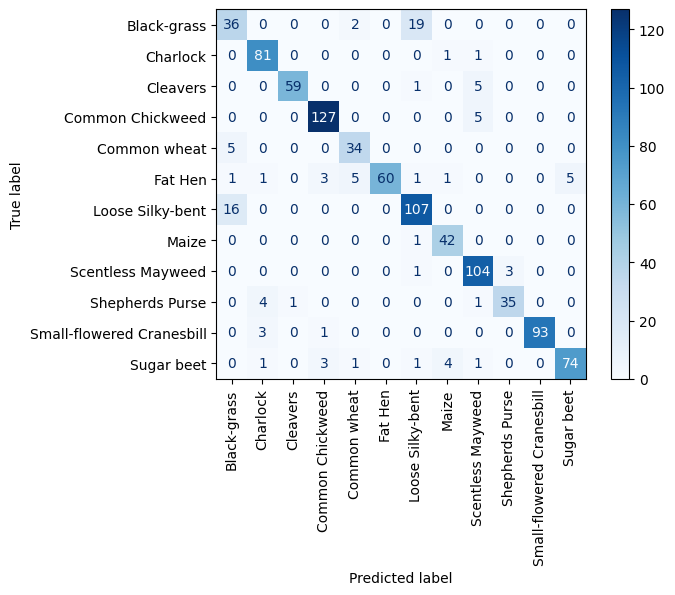

In [92]:
model.eval()

all_preds: List[int] = []
all_labels: List[int] = []
with torch.no_grad():
    for images, labels in val_loader:
        images: Tensor
        labels: Tensor
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(include_values=True, cmap="Blues", ax=None, xticks_rotation="vertical")
plt.show()

## Prediction for Submission


In [96]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in listdir(root_dir) if f.endswith(".png")]
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Tuple[Tensor, str]:
        img_path = path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]


transform = transforms.Compose(
    [
        transforms.Resize(transform_resize),
        transforms.ToTensor(),
        transforms.Normalize(mean=transform_mean, std=transform_std),
    ]
)

test_dataset = TestDataset(root_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

print(f"Test dataset length: {len(test_dataset)}")

Test dataset length: 794


In [97]:
predictions = []
with torch.no_grad():
    for images, image_names in test_loader:
        images: Tensor
        image_names: List[str]

        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for image_name, pred in zip(image_names, preds):
            predictions.append(
                {"file": image_name, "species": dataset.classes[pred.item()]}
            )

submission_file = (
    DATA_ROOT / f"submission-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(submission_file, index=False)

print(f"Predictions saved to '{submission_file}':")
print(predictions_df.head())

Predictions saved to 'data/submission-2024-12-17_13-16-34.csv':
            file           species
0  1b490196c.png   Shepherds Purse
1  85431c075.png  Loose Silky-bent
2  506347cfe.png          Cleavers
3  7f46a71db.png        Sugar beet
4  668c1007c.png          Charlock
